# Clustering and unsupervised learning

The simplest version of your task is to produce two representations of the 40-volume course corpus:

1. A plausible topic model using latent Dirichlet allocation
1. A _k_-means clustering on the basis of (normalized) word frequencies

The _k_-means clustering should take the form of cluster assignments per volume, as illustrated in the textbook. The topic model should be represented as a list of keywords associated with each topic, again as shown in the textbook.

There is at least one thing you'll need to do in addition to the textbook examples:

* Use the topic model output (or any other method) to uncover and remove additional proper names from your data.

There are a bunch of proper names in the corpus. As we discussed in class, most of these are undesirable in the sense that they do not represent meaningful semantic (that is, subject-matter) connections between any two volumes that happen to share them. So we want to get rid of them. 

One way to do this is to build topic models repreatedly, adding names from each output run to your stopword list until you stop seeing personal names among the top keywords. Another is to remove all proper nouns or named entities of type "person" from the input data. It's up to you how you approach the problem.

To help you get started, I've supplied three large stopword lists (from Jockers, Underwood, and Goldstone) in the `'data/wordlists'` directory on GitHub. Each file name begins with 'stopwords-'. I've also given you a function to import those lists and add their content to the basic NLTK English stopwords list. You can manage your own stopword list either in your code or (better yet) as an additional stopword file that you load alongside the others.

You'll notice, too, that I've supplied a short list (just one item for now) of offensive terms that should not be removed from the corpus (because they are meaningful), but also should not be displayed in raw form in the output. The supplied `mask_offensive()` function will return a version of these words with all but the first and last two letters replaced by `'*'`. I've supplied a lightly modified version of the `normalize()` function that uses `mask_offensive()` to apply this transformation. 

## Your minimal outputs should be:

1. Topic keywords for each topic in the final version of your model, showing no (or very few) proper names in any topic.
1. Cluster assignments from a _k_-means clustering on the data with names and other stopwords removed.
1. A (very) brief discussion of your results, emphasizing your sense of how well they reflect any knowledge you may have about the books in question.

Most of the two primary tasks can be accomplished with minor modification to the code included in chapter 6 of the textbook.

## Optional ways to extend this work

If you have the time and inclination to push yourself:

* Visualize the _k_-means output in two dimensions, coloring each volume by the cluster to which it is assigned. You might want to consult the vectorization problem set answers for a model approach to this type of visualization.
* Visualize the output of your topic model using `pyLDAvis`.
* Repeat the clustering using topic fractions per document in place of word frequencies. To do this, you'll need to produce a doc-topic matrix to substitute for the doc-term matrix. You can do this by running the `.transform()` method of your trained topic model over the normalized corpus.
* Explore a range of settings for normalization, vectorization, and modeling parameters to get a feel for how they affect the output. 

In [1]:
%matplotlib inline
import os
import sys
import nltk
import unicodedata
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF, PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import groupby
from operator import itemgetter
from nltk.corpus import wordnet as wn
from nltk.cluster import KMeansClusterer
from collections import Counter
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# Where are the corpus texts on your system
text_dir = os.path.join('..', 'data', 'texts')
pickle_dir = os.path.join('..', 'data', 'pickled')
pkl_chk_dir = os.path.join('..', 'data', 'pickled_chunked')
wordlist_dir = os.path.join('..', 'data', 'wordlists')

# Import our libraries
sys.path.append(os.path.join('..', 'libraries'))
from TMN import PickledCorpusReader

plt.rcParams['figure.figsize'] = [12, 8]

# Get stop- and offensive-word lists
def get_wordlists_from_files(wordlist_dir):
    """Read stopwords and offensive terms from files in wordlist_dir, return a set for each"""
    stopwords = []
    offensive = []
    stopword_files = glob.glob(wordlist_dir+'/stop*.txt')
    offensive_files = glob.glob(wordlist_dir+'/offensive*.txt')
    for f in stopword_files:
        with open(f, 'r') as fh:
            for line in fh.readlines():
                line = line.strip()
                if line:
                    stopwords.append(line)
    for f in offensive_files:
        with open(f, 'r') as fh:
            for line in fh.readlines():
                line = line.strip()
                if line:
                    offensive.append(line)
    return set(stopwords), set(offensive)

# stopwords to filter from corpus
STOPWORDS, OFFENSIVE = get_wordlists_from_files(wordlist_dir)
STOPWORDS = set(nltk.corpus.stopwords.words('english')).union(STOPWORDS)

## LDA topic modeling

In [2]:
def identity(words):
    return words


def mask_offensive(token):
    """Make lemmatized offensive words less objectionable for display"""
    if token in OFFENSIVE:
        return token[0]+(len(token)-3)*'*'+token[-2:]
    else:
        return token

class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english'):
        self.stopwords = STOPWORDS
        self.lemmatizer = nltk.WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def normalize(self, document):
        return [
            mask_offensive(self.lemmatize(token, tag).lower())
            for paragraph in document
            for sentence in paragraph
            for (token, tag) in sentence
            if not self.is_punct(token) and not self.is_stopword(token) and tag not in ['NNP', 'NNPS']
        ]

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        return [
            self.normalize(document)
            for document in documents
        ]

class SklearnTopicModels(object):

    def __init__(self, n_components=50, estimator='LDA'):
        """
        n_components is the desired number of topics
        To use Latent Semantic Analysis, set estimator to 'LSA',
        To use Non-Negative Matrix Factorization, set estimator to 'NMF',
        otherwise, defaults to Latent Dirichlet Allocation ('LDA').
        """
        self.n_components = n_components

        if estimator == 'LSA':
            self.estimator = TruncatedSVD(n_components=self.n_components)
        elif estimator == 'NMF':
            self.estimator = NMF(n_components=self.n_components)
        else:
            self.estimator = LatentDirichletAllocation(n_components=self.n_components)

        self.model = Pipeline([
            ('norm', TextNormalizer()),
            ('tfidf', CountVectorizer(
                tokenizer=identity, 
                preprocessor=None, 
                lowercase=False,
                min_df=0.05,
                max_df=0.80
            )),
            ('model', self.estimator)
        ])


    def fit_transform(self, documents):
        self.model.fit_transform(documents)

        return self.model
    

    def get_topics(self, n=25):
        """
        n is the number of top terms to show for each topic
        """
        vectorizer = self.model.named_steps['tfidf']
        model = self.model.steps[-1][1]
        names = vectorizer.get_feature_names()
        topics = dict()

        for idx, topic in enumerate(model.components_):
            features = topic.argsort()[:-(n - 1): -1]
            tokens = [names[i] for i in features]
            topics[idx] = tokens

        return topics

In [3]:
%%time
corpus = PickledCorpusReader(pickle_dir)
skmodel = SklearnTopicModels(estimator='LDA', n_components=10)
documents = corpus.docs()

trained_model = skmodel.fit_transform(documents)
topics = skmodel.get_topics()
for topic, terms in topics.items():
    print("Topic #{}:".format(topic+1))
    print(terms)

Topic #1:
['chamber', 'castle', 'aunt', 'endeavour', 'apartment', 'chateau', 'quit', 'cottage', 'archer', 'casement', 'enquire', 'madam', 'weep', 'recollect', 'inform', 'gloom', 'frequently', 'design', 'manager', 'precede', 'request', 'traveller', 'terrace']
Topic #2:
['wheat', 'dollar', 'grandmother', 'farm', 'cent', 'market', 'hell', 'cow', 'kitchen', 'colour', 'mill', 'broker', 'grey', 'damn', 'cigar', 'desk', 'farmer', 'machine', 'grandfather', 'hotel', 'barn', 'artist', 'theatre']
Topic #3:
['ter', 'negro', 'folk', 'dat', 'color', 'colored', 'goin', 'ob', 'fer', 'kitchen', 'slave', 'lovely', 'ole', 'slavery', 'tea', 'wid', 'dere', 'ef', 'bonnet', 'presently', 'sofa', 'dey', 'fun']
Topic #4:
['minister', 'clergyman', 'bosom', 'grey', 'physician', 'behold', 'machine', 'absolutely', 'presently', 'teacher', 'reader', 'hath', 'stern', 'wilderness', 'savage', 'cloak', 'task', 'manager', 'physical', 'yonder', 'english', 'rose', 'deem']
Topic #5:
['pound', 'papa', 'uncle', 'mamma', 'club'

In [7]:
%%time 
import pyLDAvis
import pyLDAvis.sklearn
import warnings

def get_doc_topic_matrix(model, documents):
    """use fitted model to predict topics for each document"""
    norm = model.named_steps['norm']
    vectorizer = model.named_steps['tfidf']
    estimator = model.named_steps['model']
    pipe = Pipeline([
        ('norm', norm),
        ('vect', vectorizer)
    ])
    tf = pipe.fit_transform(documents)
    return estimator.transform(tf), tf

doc_topic, doc_term = get_doc_topic_matrix(trained_model, corpus.docs())

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    data = pyLDAvis.sklearn.prepare(
        trained_model.named_steps['model'], 
        doc_term, 
        trained_model.named_steps['tfidf']
    )

CPU times: user 23.5 s, sys: 308 ms, total: 23.8 s
Wall time: 27.2 s


In [8]:
pyLDAvis.display(data)

## _k_-Means

In [14]:
lemmatizer = nltk.WordNetLemmatizer()

def is_punct(token):
    # Is every character punctuation?
    return all(
        unicodedata.category(char).startswith('P')
        for char in token
    )


def wnpos(tag):
    # Return the WordNet POS tag from the Penn Treebank tag
    return {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)


def normalize(document, stopwords=STOPWORDS):
    """
    Takes a document = list of (token, pos_tag) tuples
    Removes stopwords and punctuation, lowercases, lemmatizes
    """

    for token, tag in document:
        token = token.lower().strip()

        if is_punct(token) or (token in stopwords) or (token in ['NNP', 'NNPS']):
            continue
            
        yield mask_offensive(lemmatizer.lemmatize(token, wnpos(tag)))

        
class KMeansTopics(object):

    def __init__(self, corpus, k=10):
        """
        corpus is a corpus object, e.g. a TMNCorpusReader()
        or a PickledCorpusReader() object

        k is the number of clusters
        """
        self.k = k
        self.model = None
        self.vocab = list( # Note categories are baked in. Bad form.
            set(normalize(corpus.tagged(categories=['AF', 'AM', 'BF', 'BM'])))
            ) # 'set' deduplicates the normalized vocabulary 

    def vectorize(self, document):
        """
        Vectorizes a document consisting of a list of part of speech
        tagged tokens.

        One-hot encode (binarize) the document
        """
        features = set(normalize(document))
        return np.array([token in features for token in self.vocab], np.short) #'short' = data type

    def cluster(self, corpus):
        """
        Fits the K-Means model to the given data. Like sklearn .fit() method.
        """
        cosine = nltk.cluster.util.cosine_distance
        self.model = KMeansClusterer(
            self.k, distance=cosine, avoid_empty_clusters=True)
        self.model.cluster([
            self.vectorize(
                corpus.tagged(fileid)
            ) for fileid in corpus.fileids(categories=['AF', 'AM', 'BF', 'BM'])
        ])

    def classify(self, document):
        """
        Pass through to the internal model classify. Like sklearn .transform() method.
        """
        return self.model.classify(self.vectorize(document))

In [15]:
%%time 
corpus = PickledCorpusReader(pickle_dir)

clusterer = KMeansTopics(corpus, k=4)
clusterer.cluster(corpus) # train on corpus docs

# Assign cluster labels to corpus docs
groups  = [
    (clusterer.classify(corpus.tagged(fileid)), fileid)
    for fileid in corpus.fileids(categories=['AF', 'AM', 'BF', 'BM'])
] 

# Group documents in corpus by cluster and display them
groups.sort(key=itemgetter(0)) # sort list by cluster number assigned to each doc
for group, items in groupby(groups, key=itemgetter(0)):
    for cluster, fname in items:
        print("Cluster {}: {}".format(cluster+1,fname))

Cluster 1: A-Harper-Iola_Leroy-1892-F.pickle
Cluster 1: A-James-Golden_Bowl-1904-M.pickle
Cluster 1: B-Austen-Pride_Prejudice-1813-F.pickle
Cluster 1: B-Burney-Evelina-1778-F.pickle
Cluster 1: B-Dickens-Bleak_House-1853-M.pickle
Cluster 1: B-Disraeli-Sybil-1845-M.pickle
Cluster 1: B-Eliot-Middlemarch-1869-F.pickle
Cluster 1: B-Gissing-Grub_Street-1893-M.pickle
Cluster 1: B-Thackeray-Vanity_Fair-1848-M.pickle
Cluster 1: B-Trollope-Live_Now-1875-M.pickle
Cluster 2: A-Twain-Huck_Finn-1885-M.pickle
Cluster 3: A-Cather-Antonia-1918-F.pickle
Cluster 3: A-Chopin-Awakening-1899-F.pickle
Cluster 3: A-Crane-Maggie-1893-M.pickle
Cluster 3: A-Dreiser-Sister_Carrie-1900-M.pickle
Cluster 3: A-Gilman-Herland-1915-F.pickle
Cluster 3: A-Norris-Pit-1903-M.pickle
Cluster 3: A-Wharton-Age_Innocence-1920-F.pickle
Cluster 3: B-Woolf-Mrs_Dalloway-1925-F.pickle
Cluster 4: A-Alcott-Little_Women-1868-F.pickle
Cluster 4: A-Chesnutt-Marrow-1901-M.pickle
Cluster 4: A-Davis-Life_Iron_mills-1861-F.pickle
Cluster 4: 

### Visualize _k_-means

In [16]:
# Repeat vectorization for input to PCA
vec = [clusterer.vectorize(corpus.tagged(f)) for f in corpus.fileids()]
pca = PCA()
reduced = pca.fit_transform(vec)

In [17]:
reduced.shape # Note PCA limits max dimensions to number of samples

(40, 40)

In [18]:
pca.explained_variance_ratio_[0:2] # How much variance captured in first two dimensions?

array([0.10436671, 0.04994324])

In [19]:
# Get cluster numbers and filename labels
groups.sort(key=itemgetter(1)) # Sort by filename
labels, filenames = zip(*groups) # Make two lists from a list of 2-tuples

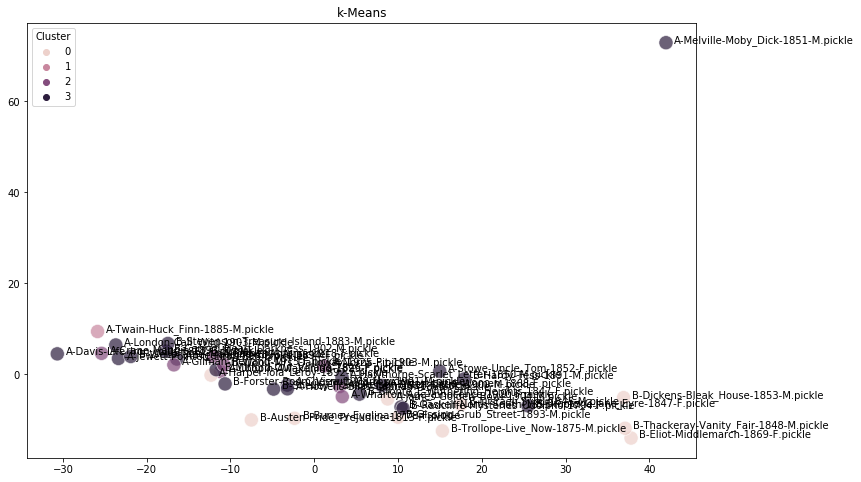

In [23]:
# Draw the figure
fig = sns.scatterplot(reduced[:,0], reduced[:,1], hue=labels, s=200, alpha=0.7)
for i in range(0,reduced.shape[0]):
     fig.text(reduced[:,0][i]+1, reduced[:,1][i], filenames[i], 
     horizontalalignment='left', 
     size='medium', color='black', weight='light')
plt.legend(title="Cluster")
plt.title("k-Means")
plt.show()

## Hierarchical clustering

AKA, agglomerative clustering. Cluster by increasing distances between points. For interest only.

In [24]:
# Note that some functions used here are defined above ...

class HierarchicalTopics(object):

    def __init__(self, corpus):
        """
        corpus is a corpus object, e.g. a TMNCorpusReader()
        or PickledCorpusReader() object
        """
        self.model = None
        self.vocab = list(
            set(normalize(corpus.tagged(categories=['AF', 'AM', 'BF', 'BM'])))
        )

    def vectorize(self, document):
        """
        Vectorizes a document consisting of a list of part of speech
        tagged tokens.

        One-hot encode the set of documents
        """
        features = set(normalize(document))
        return np.array([token in features for token in self.vocab], np.short)

    def cluster(self, corpus):
        """
        Fits the AgglomerativeClustering model to the given data.
        """
        self.model = AgglomerativeClustering() # By default, linkage='ward'

        self.model.fit_predict([
            self.vectorize(
                corpus.tagged(fileid)) for fileid in
                corpus.fileids(categories=['AF', 'AM', 'BF', 'BM']
                           )
        ])

        self.labels = self.model.labels_
        self.children = self.model.children_

    def plot_dendrogram(self, **kwargs):
        # Distances between each pair of children
        # Misleadingly named; positional info is in children.
        # These arrays are more like ordering info
        distance = np.arange(self.children.shape[0])
        position = np.arange(self.children.shape[0])

        # Create linkage matrix and then plot the dendrogram
        linkage_matrix = np.column_stack([
            self.children, distance, position]
        ).astype(float)

        # Plot the corresponding dendrogram
        fig, ax = plt.subplots(figsize=(15, 10))  # set size
        ax = dendrogram(linkage_matrix, **kwargs)
        plt.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labelrotation=-90)
        plt.tight_layout()
        plt.show()

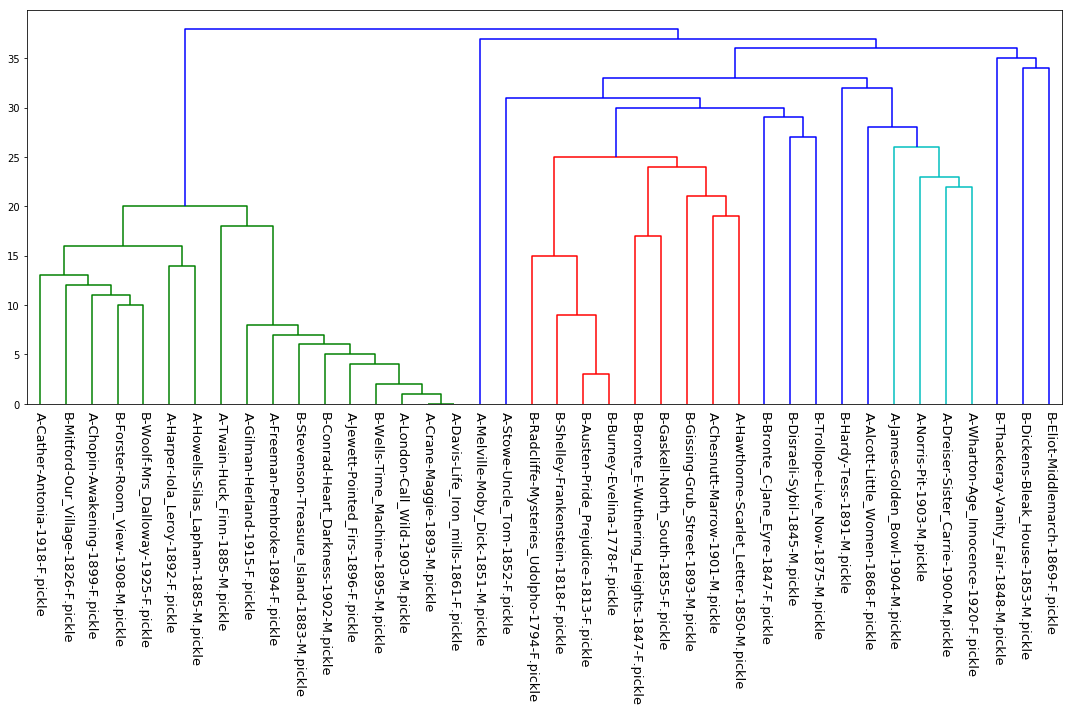

CPU times: user 41.8 s, sys: 370 ms, total: 42.2 s
Wall time: 42.4 s


In [25]:
%%time
labels = []
label_by = 'files' # Label leaves by file name; use 'terms' to label by most common terms

for fileid in corpus.fileids(categories=['AF', 'AM', 'BF', 'BM']):
    if label_by=='terms':
        terms = []
        for term, count in Counter(list(normalize(corpus.tagged(fileid)))).most_common(10):
            terms.append(term)
        labels.append(terms)
    else:
        labels.append(fileid)

clusterer = HierarchicalTopics(corpus)
clusterer.cluster(corpus)
clusterer.plot_dendrogram(labels=labels, leaf_font_size=13)

## Cluster by topical content

Note that the relevant input data are generated in the section of topic modeling, above.

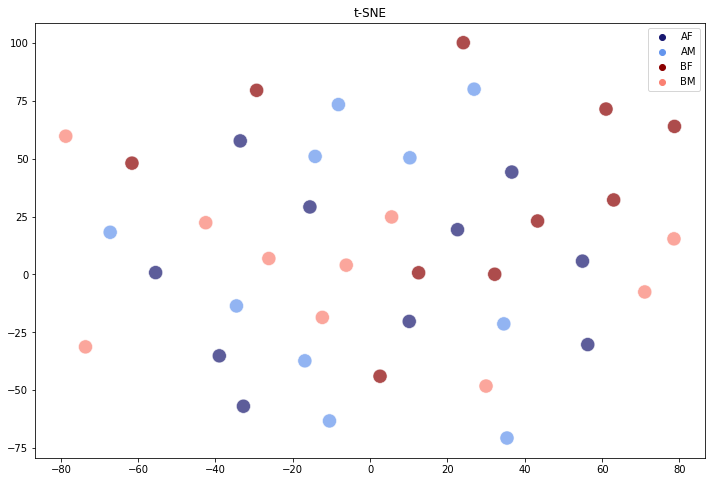

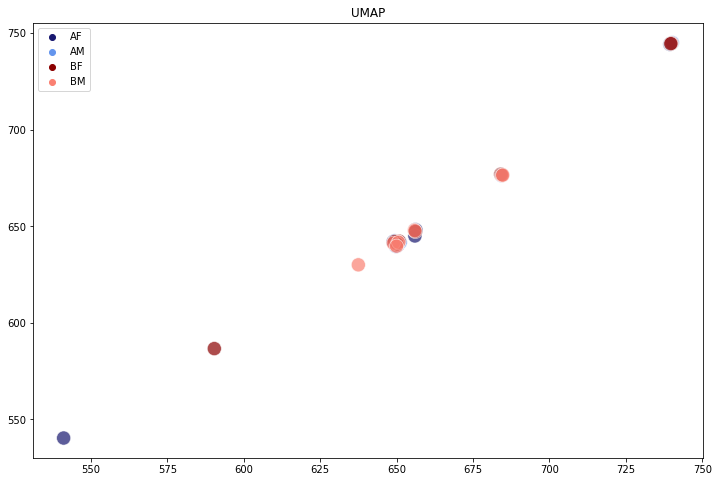

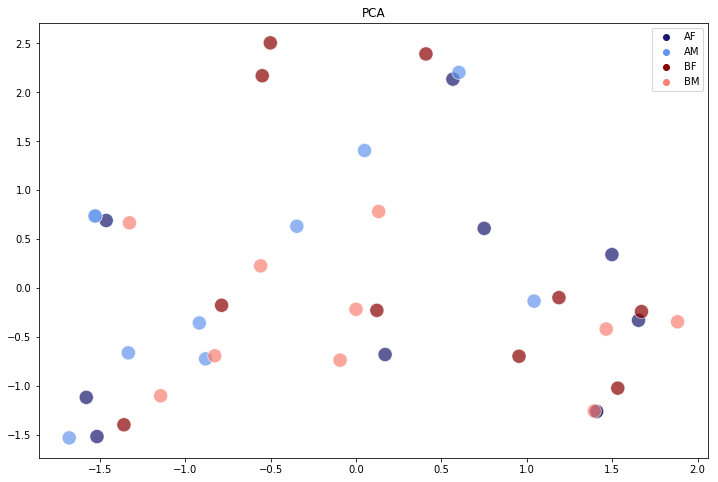

In [29]:
# Scale, reduce, plot
from umap import UMAP # UMAP not a standard package; others imported above

scaler = StandardScaler() # Scaler to transform inputs to z-scores

pca = PCA(n_components=2).fit_transform(scaler.fit_transform(doc_topic))
tsne = TSNE().fit_transform(scaler.fit_transform(doc_topic))
umap = UMAP(metric='cosine', angular_rp_forest=True).fit_transform(scaler.fit_transform(doc_topic))

# Get document labels
nations = [] # Just the nation labels (e.g., 'A')
natgens = [] # Nation-gender labels (e.g., 'AF')
genders = [] # Just gender labels (e.g., 'F')

for file in corpus.fileids():
    a, b, c = corpus.categories(fileids=file)
    nations.append(a)
    natgens.append(b)
    genders.append(c)

# Set plotting colors
colors = {
    'AM': 'cornflowerblue',
    'AF': 'midnightblue',
    'BM': 'salmon',
    'BF': 'darkred'
}

# Plot by nation and gender
for rep, name in [(tsne, 't-SNE'), (umap, 'UMAP'), (pca, 'PCA')]:
    sns.scatterplot(rep[:,0], rep[:,1], hue=natgens, palette=colors, s=200, alpha=0.7)
    plt.title(name)
    plt.show()

## Cluster by full term info

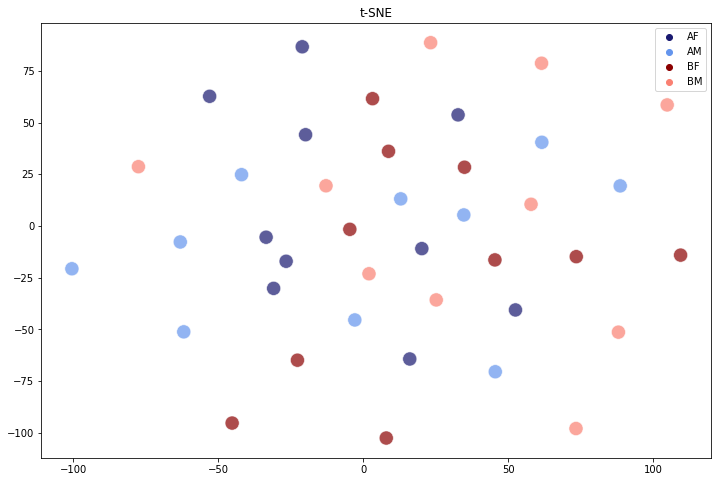

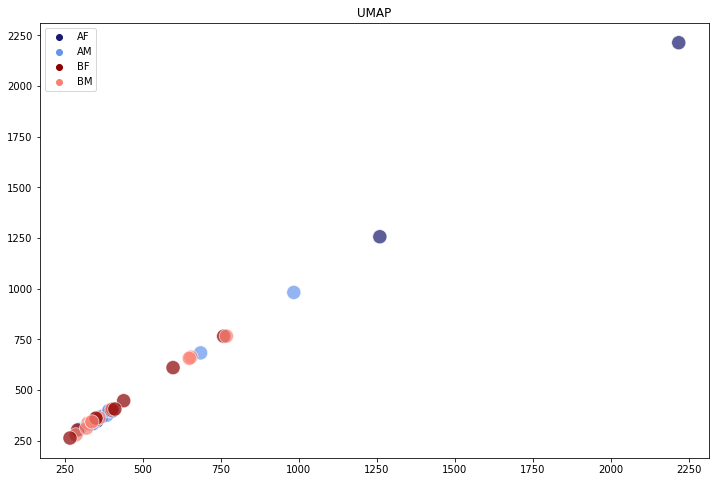

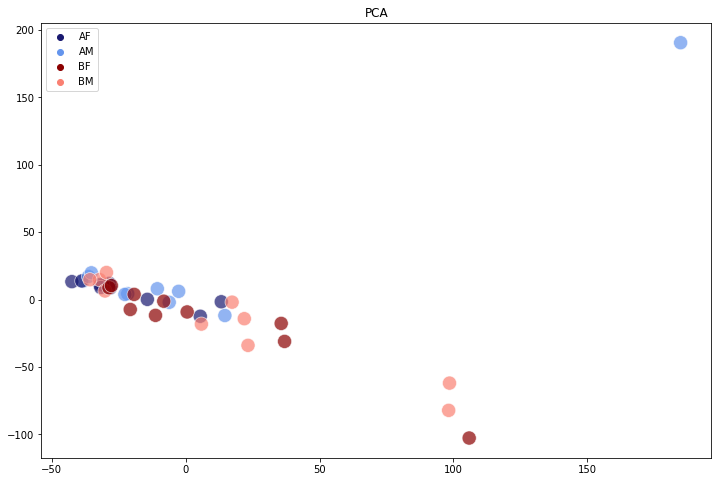

In [30]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    tsne_tf = TSNE().fit_transform(scaler.fit_transform(doc_term.toarray()))
    umap_tf = UMAP(metric='cosine', n_neighbors=5, angular_rp_forest=True).fit_transform(scaler.fit_transform(doc_term.toarray()))
    pca_tf  = PCA(n_components=2).fit_transform(scaler.fit_transform(doc_term.toarray()))

# Get document labels
nations = [] # Just the nation labels (e.g., 'A')
natgens = [] # Nation-gender labels (e.g., 'AF')
genders = [] # Just gender labels (e.g., 'F')

for file in corpus.fileids():
    a, b, c = corpus.categories(fileids=file)
    nations.append(a)
    natgens.append(b)
    genders.append(c)

# Set plotting colors
colors = {
    'AM': 'cornflowerblue',
    'AF': 'midnightblue',
    'BM': 'salmon',
    'BF': 'darkred'
}

# Plot by nation and gender
for rep, name in [(tsne_tf, 't-SNE'), (umap_tf, 'UMAP'), (pca_tf, 'PCA')]:
    sns.scatterplot(rep[:,0], rep[:,1], hue=natgens, palette=colors, s=200, alpha=0.7)
    plt.title(name)
    plt.show()